# spanish to English

In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf

# import tensorflow_text as tf_text


2024-09-21 15:45:17.867283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 15:45:17.875228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 15:45:17.884893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 15:45:17.887570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 15:45:17.894603: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# utility code
class ShapeChecker:
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(
                    f"Shape mismatch for dimension: '{name}'\n"
                    f"    found: {new_dim}\n"
                    f"    expected: {old_dim}\n"
                )


In [3]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    "spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)

path_to_file = pathlib.Path(path_to_zip).parent / "spa-eng/spa.txt"


In [4]:
def load_data(path):
    text = path.read_text(encoding="utf=8")

    lines = text.splitlines()
    pairs = [line.split("\t") for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context


In [5]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print(target_raw[-1])


Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [6]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# creates a boolean mast for samples selected for training or not
# meaning a sample that is True will be assigned to training set and false will not
is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

print(is_train.shape)

train_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)


train_raw


(118964,)


I0000 00:00:1726947920.372701    6024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726947920.390186    6024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726947920.390224    6024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726947920.392833    6024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726947920.392868    6024 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [7]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break


tf.Tensor(
[b'A ti no te gustan las historias de amor, \xc2\xbfno es cierto?'
 b'Mucha gente asisti\xc3\xb3 a esa reuni\xc3\xb3n.'
 b'Dos caf\xc3\xa9s, por favor.' b'Tom tiene una sorpresa para Mary.'
 b'Tom no quiere desanimar a Mary.'], shape=(5,), dtype=string)

tf.Tensor(
[b"You don't like love stories, do you?"
 b'Many people attended that meeting.' b'Two coffees, please.'
 b'Tom has a surprise for Mary.' b"Tom doesn't want to discourage Mary."], shape=(5,), dtype=string)


# TExt preprocessing

In [8]:
# from tensorflow import text


example_text = tf.constant("¿Todavía está en casa?")
print(example_text.numpy())
# print(tf.text.normalize_utf8(example_text, "NFKD").numpy())


b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'


In [9]:
# Since tensorflow_text doesn't work
import unicodedata

"""
*** FORMS *** 
NFC
NFD
NFKC
NFKD

"""
example = "¿Todavía está en casa?"


def unicode_normalize(form, src):
    # src = str(tf.get_static_value(src))
    norm = unicodedata.normalize(form, src)
    # print(f"{form}: {norm} ({len(norm.encode('utf-8'))} bytes)")
    return norm


unicode_normalize("NFKD", example)


'¿Todavía está en casa?'

In [10]:
# import unicodedata


# def conv_and_print(form):
#     src = "¿Todavía está en casa?"
#     norm = unicodedata.normalize(form, src)
#     print(f"{form}: {norm} ({len(norm.encode('utf-8'))} bytes)")


# conv_and_print("NFC")
# conv_and_print("NFD")
# conv_and_print("NFKC")
# conv_and_print("NFKD")


In [11]:
def tf_lower_and_split_punct(text):
    # Split accented Characters.
    # text = unicode_normalize("NFKD", text)
    text = tf.strings.lower(text)

    # keep space, a to z, and selcet punctuation
    text = tf.strings.regex_replace(text, "[^ a-z.?!,¿]", "")

    # add spaces around punctuation.
    text = tf.strings.regex_replace(text, "[.?!,¿]", r" \0 ")

    # strip white space.
    text = tf.strings.strip(text)

    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text


In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())


¿Todavía está en casa?
[START] ¿ todava est en casa ? [END]


# Vectorization

In [13]:
max_cocab_size = 5000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, max_tokens=max_cocab_size, ragged=True
)


## Spanish text vectorizer

In [14]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# print first 10 words from the vocabulary
context_text_processor.get_vocabulary()[:10]


2024-09-21 15:45:28.066262: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['', '[UNK]', '[START]', '[END]', '.', 'de', 'que', 'a', 'no', 'tom']

## English text vectorizer

In [15]:
max_vocab_size = 5000

target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size, ragged=True
)
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]


2024-09-21 15:45:35.310612: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

### convert batch of strings to batch of token IDs

In [16]:
example_tokens = context_text_processor(example_context_strings)
print(example_tokens.shape)
example_tokens[:3]


(64, None)


<tf.RaggedTensor [[2, 7, 178, 8, 32, 312, 36, 2446, 5, 660, 19, 12, 8, 15, 467, 11, 3],
 [2, 353, 173, 1, 7, 120, 401, 4, 3], [2, 89, 1, 19, 21, 74, 4, 3]]>

In [17]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
" ".join(tokens)


'[START] a ti no te gustan las historias de amor , ¿ no es cierto ? [END]'

Text(0.5, 1.0, 'Mask')

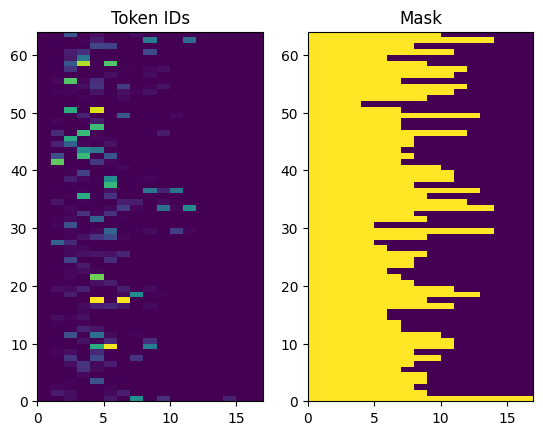

In [18]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title("Mask")


## Process the dataset

In [19]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:, :-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)


In [20]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy())
    print()
    print(ex_tar_in[0, :10].numpy())
    print(ex_tar_out[0, :10].numpy())


[  2  31 113  71  23   1   4   3   0   0]

[  2  26 204   7  35  10   1   4   0   0]
[ 26 204   7  35  10   1   4   3   0   0]


# Encoder/ decoder

### Encoder
#
1. Takes a list of token IDs (from context_text_processor).
2. Looks up an embedding vector for each token (Using a layers.Embedding).
3. Processes the embeddings into a new sequence (Using a bidirectional layers.GRU).
4. Returns the processed sequence. This will be passed to the attention head.

In [21]:
UNITS = 256


class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size, units, mask_zero=True
        )

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode="sum",
            layer=tf.keras.layers.GRU(
                units,
                # Return the sequence and state
                return_sequences=True,
                recurrent_initializer="glorot_uniform",
            ),
        )

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, "batch s")

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, "batch s units")

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, "batch s units")

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context


In [22]:
# testing
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f"Context tokens, shape (batch, s): {ex_context_tok.shape}")
print(f"Encoder output, shape (batch, s, units): {ex_context.shape}")


Context tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 256)


2024-09-21 15:45:36.777470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


## Atention layer

In [23]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(
            key_dim=units, num_heads=1, **kwargs
        )
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, "batch t units")
        shape_checker(context, "batch s units")

        attn_output, attn_scores = self.mha(
            query=x, value=context, return_attention_scores=True
        )

        shape_checker(x, "batch t units")
        shape_checker(attn_scores, "batch heads t s")

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, "batch t s")
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x


In [24]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(
    target_text_processor.vocabulary_size(), output_dim=UNITS, mask_zero=True
)

ex_tar_embed = embed(ex_tar_in)
result = attention_layer(ex_tar_embed, ex_context)

print(f"Context sequence, shape (batch, s, units): {ex_context.shape}")
print(f"Target sequence, shape (batch, t, units): {ex_tar_embed.shape}")
print(f"Attention result, shape (batch, t, units): {result.shape}")
print(
    f"Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}"
)


/home/mbeleck/anaconda3/envs/tf2-gpu/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mbeleck/anaconda3/envs/tf2-gpu/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/mbeleck/anaconda3/envs/tf2-gpu/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will

Context sequence, shape (batch, s, units): (64, 17, 256)
Target sequence, shape (batch, t, units): (64, 16, 256)
Attention result, shape (batch, t, units): (64, 16, 256)
Attention weights, shape (batch, t, s):    (64, 16, 17)


/home/mbeleck/anaconda3/envs/tf2-gpu/lib/python3.12/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [25]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)


array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.0000001, 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       ], dtype=float32)

Text(0.5, 1.0, 'Mask')

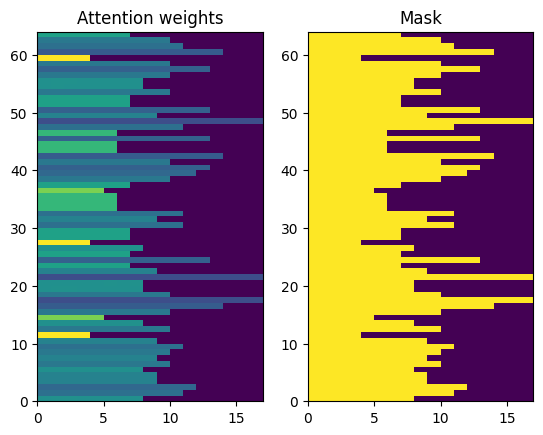

In [26]:
attention_weights = attention_layer.last_attention_weights
mask = (ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask * attention_weights[:, 0, :])
plt.title("Attention weights")

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title("Mask")


# Decoder

In [27]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(), mask_token="", oov_token="[UNK]"
        )
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token="",
            oov_token="[UNK]",
            invert=True,
        )
        self.start_token = self.word_to_id("[START]")
        self.end_token = self.word_to_id("[END]")

        self.units = units

        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size, units, mask_zero=True
        )

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(
            units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)


In [28]:
@Decoder.add_method
def call(self, context, x, state=None, return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(x, "batch t")
    shape_checker(context, "batch s units")

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, "batch t units")

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, "batch t units")

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, "batch t units")
    shape_checker(self.last_attention_weights, "batch t s")

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, "batch t target_vocab_size")

    if return_state:
        return logits, state
    else:
        return logits


In [29]:
decoder = Decoder(target_text_processor, UNITS)


In [30]:
logits = decoder(ex_context, ex_tar_in)

print(f"encoder output shape: (batch, s, units) {ex_context.shape}")
print(f"input target tokens shape: (batch, t) {ex_tar_in.shape}")
print(f"logits shape shape: (batch, target_vocabulary_size) {logits.shape}")


ValueError: Exception encountered when calling Decoder.call().

[1mtoo many values to unpack (expected 2)[0m

Arguments received by Decoder.call():
  • context=tf.Tensor(shape=(64, 17, 256), dtype=float32)
  • x=tf.Tensor(shape=(64, 16), dtype=int64)
  • state=None
  • return_state=False